# A Structured Self-attentive Sentence Embedding

After word embedding is applied to the representation of words, natural language processing(NLP) has been effectively improved in many ways. Along with the widespread use of word embedding, many techniques have been developed to express the semantics of sentences by words, such as:
1. The vector representation of multiple words in a sentence is concatenated or weighted to obtain a vector to represent the sentence.
2. Convolution(CNN) and maximum pooling(MaxPooling) on the matrix of all the word vectors of the sentence, using the final result to represent the semantics of the sentence.
3. Unroll the sentence according to the time step of the word, input the vector representation of each word into a recurrent neural network(RNN), and use the output of the last time step of the RNN as the semantic representation of the sentence.

The above method solves the problem of sentence meaning in a certain extent in many aspects. When concatenating is used in method one, if the word of the sentence is too long and the vector dimension of the word is slightly larger, then the vector dimension of the sentence will be particularly large, and the internal interaction between the words of the sentence is not taken into account. The use of weighted averaging is not accurate and does not adequately express the impact of each word on sentence semantics. Many useful word meanings may be lost in Method2. The third method selects the output of the last step. If the sentence is too long, the output of the last step does not accurately express the semantics of the sentence.

Based on the above mentioned method, Zhouhan Lin, Minwei Feng et al. published a paper [A Structured Self-attentive Sentence Embedding](https://arxiv.org/pdf/1703.03130.pdf)[1] in 2017, proposed a method based on self-attention structure for sentence embedding and applied to user's reviews classification, textual entailment and other tasks. In the end, good results were obtained.

In this tutorial, we will use [GluonNLP](https://gluon-nlp.mxnet.io/index.html) to reproduce the model structure in "A Structured Self-attentive Sentence Embedding" and apply it to [Yelp Data's review star rating data set](https://www.yelp.com/dataset/challenge) for classification.

## Import Related Packages

In [1]:
import os
import json
import zipfile
import time
import itertools

import numpy as np
import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import gluon, nd, init
from mxnet.gluon import nn, rnn
from mxnet import autograd, gluon, nd
from d2l import try_gpu
import pandas as pd

# iUse sklearn's metric function to evaluate the results of the experiment
from sklearn.metrics import accuracy_score, f1_score

# fixed random number seed
np.random.seed(9102)
mx.random.seed(9102)

## Data pipeline

### Load The Reviews of Yelp Data

[Yelp users' review dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset) is formatted as json. The original paper selected 500K documents as the training set, 2K as the validation set, and 2Kas the test set. For easier reproducibility of the experiment, we subsampled 198K documents from this dataset as training set and 2K documents as validation set.
Each sample in the data is a user's comment, the language is English, and each comment category is marked 1-5, representing 5 different emotional colors.

In [14]:
data_folder = 'data/imdb/'
file_name = 'train.csv'
file_path = data_folder + file_name

## load json data.
nrows = 100000
data = pd.read_csv(file_path, nrows=nrows)

# create a list of review a label paris.
dataset = [[left, right, int(label)] for left, right, label in \
           zip(data['review_text'], data['plot_summary'], data['is_spoiler'])]

# randomly divide one percent from the training set as a verification set.
train_dataset, valid_dataset = nlp.data.train_valid_split(dataset, 0.2)
len(train_dataset), len(valid_dataset)

(80000, 20000)

### Data Processing

The purpose of the following code is to process the raw data so that the processed data can be used for model training and prediction. We will use the `SpacyTokenizer` to split the document into tokens, `ClipSequence` to crop the comments to the specified length, and build a vocabulary based on the word frequency of the training data. Then we attach the [Glove](https://nlp.stanford.edu/pubs/glove.pdf)[2]  pre-trained word vector to the vocabulary and convert each token into the corresponding word index in the vocabulary.
Finally get the standardized training data set and verification data set

In [15]:
# tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')

# length_clip takes as input a list and outputs a list with maximum length 300.
length_clip_review = nlp.data.ClipSequence(300)
length_clip_plot = nlp.data.ClipSequence(100)

def preprocess(x):

    # now the first element in tuple is review, second plot and third label
    try:
        left, right, label = x[0], x[1], int(x[2])
        assert(type(left)==type('str') and type(right)==type('str'))
        assert(label==0 or label==1)
    except:
        print(left, right)
        left, right=str(left), str(right)
    # clip the length of review words
    left, right = length_clip_review(tokenizer(left.lower())), \
                  length_clip_plot(tokenizer(right.lower()))
    return left, right, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()

    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.ArrayDataset(pool.map(preprocess, dataset))
        lengths = gluon.data.ArrayDataset(pool.map(get_length, dataset))
    end = time.time()

    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
valid_dataset, valid_data_lengths = preprocess_dataset(valid_dataset)

Standard playboy production - bad script, sexy women Just a standard softcore flick from the playboy factory - so you know what to expect: Bad script, sexy women; Tawny Kitaen is gorgeous and prevents the whole movie from drifting into oblivion (imho). nan
Done! Tokenizing Time=37.75s, #Sentences=80000
Done! Tokenizing Time=9.98s, #Sentences=20000


In [16]:
# create vocab
train_seqs = [sample[0]+sample[1] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))

vocab = nlp.Vocab(counter, max_size=20000)

# load pre-trained embedding, Glove
embedding_weights = nlp.embedding.GloVe(source='glove.twitter.27B.200d')
vocab.set_embedding(embedding_weights)
print(vocab)

# NOTE: to use the same encoder, we need to ensure that two inputs are of the same length
# this is achieved by manual padding
def token_to_idx(x):
    return vocab[x[0]], vocab[x[1]], x[2]

# A token index or a list of token indices is returned according to the vocabulary.
with mp.Pool() as pool:
    train_dataset = pool.map(token_to_idx, train_dataset)
    valid_dataset = pool.map(token_to_idx, valid_dataset)

Vocab(size=20004, unk="<unk>", reserved="['<pad>', '<bos>', '<eos>']")


In [17]:
idx = vocab.embedding.token_to_idx['xmen']
idx, vocab.embedding.idx_to_vec[idx]

(15531, 
 [ 7.3501e-01  2.3659e-01  8.1485e-02  6.9116e-02 -8.2966e-02  5.1736e-01
  -2.2106e-01  1.2918e-01 -1.4550e-01  1.8944e-01  3.4552e-01 -2.7266e-01
   2.5191e-01  4.1132e-02 -2.9738e-01 -1.9861e-01  2.3085e-01  2.0603e-01
  -4.2740e-02  2.6072e-01 -6.5018e-01  5.0332e-02  1.6095e-01 -5.4888e-01
  -2.7124e-01  1.1846e-01 -5.7249e-02 -3.1976e-01 -1.1128e-01  1.8404e-01
  -2.0640e-01  4.7762e-01  3.5954e-02 -1.4585e-02 -6.9505e-02  6.1174e-01
   4.4875e-01 -5.2554e-01 -1.5218e-01  3.7220e-01  3.6481e-01 -4.6937e-01
  -9.1761e-02 -6.8574e-01 -5.4097e-01  8.5439e-01 -3.5236e-01 -2.0113e-01
  -2.0686e-01 -1.0377e+00  4.0393e-01 -7.6687e-01 -2.3442e-01  2.8207e-01
  -8.8382e-01 -5.5162e-03  6.4569e-01 -6.6990e-02  6.1193e-01  7.7833e-02
   1.2878e-01  1.1748e-01 -4.4662e-01 -1.5219e-01 -9.0765e-01  6.0395e-01
   1.4690e-01  2.9322e-01 -2.7783e-01 -5.7250e-01 -3.1507e-01  2.0820e-01
  -1.5681e-01  1.1861e+00  5.2476e-01  3.4866e-01 -4.0212e-01 -3.9851e-01
   2.9129e-01 -2.7880e-01  2.

## Bucketing and DataLoader
Since each sentence may have a different length, we need to use `Pad` to fill the sentences in a minibatch to equal lengths so that the data can be quickly tensored on the GPU. At the same time, we need to use `Stack` to stack the category tags of a batch of data. For convenience, we use `Tuple` to combine `Pad` and `Stack`.

In order to make the length of the sentence pad in each minibatch as small as possible, we should make the sentences with similar lengths in a batch as much as possible. In light of this, we consider constructing a sampler using `FixedBucketSampler`, which defines how the samples in a dataset will be iterated in a more economic way.

Finally, we use `DataLoader` to build a data loader for the training. dataset and validation dataset. The training dataset requires FixedBucketSampler, but the validation dataset doesn't require the sampler.

In [18]:
batch_size = 64
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():
    # Construct the DataLoader Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(nlp.data.batchify.Pad(axis=0), \
                                          nlp.data.batchify.Pad(axis=0),
                                          nlp.data.batchify.Stack())

    # n this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # train_dataloader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # valid_dataloader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

FixedBucketSampler:
  sample_num=80000, batch_num=1209
  key=[39, 68, 97, 126, 155, 184, 213, 242, 271, 300]
  cnt=[199, 1814, 3234, 4130, 10014, 10455, 7683, 5820, 4696, 31955]
  batch_size=[246, 141, 98, 76, 64, 64, 64, 64, 64, 64]


In [13]:
# experiement one the two dataloaders
# for left, right, label in train_dataloader:
    # print(left.shape, right.shape, label.shape)

## Model Structure

In the original paper, the representation of the sentence is: firstly, the sentence is disassembled into a list corresponding to the word, then the words are unrolled in order, and the word vector of each word is calculated as the input of each step of the [bidirectional LSTM neural network layer](https://www.bioinf.jku.at/publications/older/2604.pdf)[3]. Taking the output of each step of the bidirectional LSTM network layer, a matrix H is obtained. Suppose the hidden_dim of the bidirectional LSTM is `u`, the word length of the sentence is `n`, then the dimension of the last H is `n-by-2u`.  For example, the sentence "this movie is amazing" would be represented as:
![](Bi-LSTM-Rep.png)

Attention is like when we are looking at things, we always give different importance to things in the scope of the perspective. For example, when we are communicating with people, our eyes will always pay more attention to the face of the communicator, not to the edge of other perspectives. So when we want to express the sentence, we can pay different attention to the output H of the bidirectional LSTM layer.
![](attention-nlp.png)
$$
A = Softmax(W_{s2}tanh(W_{s1}H^T))
$$

Here, W<sub>s1</sub> is a weight matrix with the shape: d<sub>a</sub>-by-2u, where d<sub>a</sub> is a hyperparameter.
W<sub>s2</sub> is a weight matrix with the shape: r-by-d<sub>a</sub>, where r is the number of different attentions you want to use.

When the attention matrix A and the output H of the LSTM are obtained, the final representation is obtained by M=AH.



We can first customize a layer of attention, specify the number of hidden nodes att_unit and the number of attention channels att_hops.

In [19]:
# custom attention layer
# in this class, we want to implement the operation:
# softmax(W_2 * tanh(W_1 * H))
# where H is the word embedding of the whole sentence, of shape (num_of_word, embed_size)
class SelfAttention(nn.HybridBlock):
    def __init__(self, att_unit, att_hops, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            # this layer is tanh(w_1 * H), the att_unit corresponds to d_a in the essay
            self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)
            # this layer implements the multiple hops
            self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

    def hybrid_forward(self, F, x): # F is the backend which implements the tensor operation
        # x shape: [batch_size, seq_len, embedding_width]
        # ut shape: [batch_size, seq_len, att_unit]
        ut = self.ut_dense(x) # batch_size * seq_len [* embed_size * embed_size *] att_unit
        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)# batch_size * seq_len [* att_unit * att_unit *] att_hops

        # att shape: [batch_size,  att_hops, seq_len]
        # softmax is performed along the seq_len dimension
        att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(att, x)
        # output is the weighted matrix representation of the matrix
        # att is the weighted vector we use as attention
        return output, att
    
# d_a = 20, hops = 5
print(SelfAttention(20, 5))

SelfAttention(
  (ut_dense): Dense(None -> 20, Activation(tanh))
  (et_dense): Dense(None -> 5, linear)
)


When the number of samples for labels are very unbalanced, applying different weights on different labels may improve the performance of the model. This can be seen as a method to correct [covariance shift](http://d2l.ai/chapter_multilayer-perceptrons/environment.html).

In [20]:
class WeightedSoftmaxCE(nn.HybridBlock):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def hybrid_forward(self, F, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = F.reshape(label, shape=(-1, ))
            label = F.one_hot(label, depth)
        if not self.from_logits:
            pred = F.log_softmax(pred, -1)

        weight_label = F.broadcast_mul(label, class_weight)
        loss = -F.sum(pred * weight_label, axis=-1)

        # return F.mean(loss, axis=0, exclude=True)
        return loss

In [21]:
class SelfAttentiveBiLSTM(nn.HybridBlock):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, natt_unit, natt_hops, \
                 nfc, nclass, # these two params are not used currrently
                 drop_prob, pool_way, prune_p=None, prune_q=None, **kwargs):
        super(SelfAttentiveBiLSTM, self).__init__(**kwargs)
        with self.name_scope():
            # now we switch back to shared layers
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            
            self.bilstm = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, \
                                        bidirectional=True)
            
            self.att_encoder = SelfAttention(natt_unit, natt_hops)
            # this layer is used to output the final class
            self.output_layer = nn.Dense(nclass, activation='tanh')
            
            self.dense_p, self.dense_q = None, None
            if all([prune_p, prune_q]):
                self.dense_p = nn.Dense(prune_p, activation='tanh', flatten=False)
                self.dense_q = nn.Dense(prune_q, activation='tanh', flatten=False)

            self.drop_prob = drop_prob
            self.pool_way = pool_way

    def hybrid_forward(self, F, inp_left, inp_right):
        # inp is a list containing left_text and right_text
        # their size: [batch, token_idx]
        # inp_embed_left/right size: [batch, seq_len, embed_size]
        inp_embed_left = self.embedding_layer(inp_left)
        inp_embed_right = self.embedding_layer(inp_right)
        # rnn requires the first dimension to be the time steps
        h_output_left = self.bilstm(F.transpose(inp_embed_left, axes=(1, 0, 2)))
        h_output_right = self.bilstm(F.transpose(inp_embed_right, axes=(1, 0, 2)))
        # att_output: [batch, att_hops, emsize]
        output_left, att_left = self.att_encoder(F.transpose(h_output_left, \
                                                             axes=(1, 0, 2)))
        output_right, att_right = self.att_encoder(F.transpose(h_output_right, \
                                                               axes=(1, 0, 2)))
        '''
        FIXME: now this code will only work with flatten
        '''
        dense_input_left, dense_input_right = None, None
        if self.pool_way == 'flatten':
            dense_input_left = F.Dropout(F.flatten(output_left), self.drop_prob)
            dense_input_right = F.Dropout(F.flatten(output_right), self.drop_prob)
        else:
            raise NotImplemented
        '''
        elif self.pool_way == 'mean':
            dense_input = F.Dropout(F.mean(att_output, axis=1), self.drop_prob)
        elif self.pool_way == 'prune' and all([self.dense_p, self.dense_q]):
            # p_section: [batch, att_hops, prune_p]
            p_section = self.dense_p(att_output)
            # q_section: [batch, emsize, prune_q]
            q_section = self.dense_q(F.transpose(att_output, axes=(0, 2, 1)))
            dense_input = F.Dropout(F.concat(F.flatten(p_section), F.flatten(q_section), dim=-1), self.drop_prob)
        '''
        dense_input = dense_input_left - dense_input_right
        output = self.output_layer(dense_input)

        return output, att_left, att_right

## Configure parameters and build models

The resulting `M` is a matrix, and the way to classify this matrix is `flatten`, `mean` or `prune`. Prune is a way of trimming parameters proposed in the original paper and has been implemented here.

In [22]:
vocab_len = len(vocab)
emsize = 200   # word embedding size
nhidden = 300    # lstm hidden_dim
nlayers = 4     # lstm layers
natt_unit = 300     # the hidden_units of attention layer
natt_hops = 30    # the channels of attention

# these two variables are not used, preserve for now
nfc = 512
nclass = 2

drop_prob = 0
pool_way = 'flatten'    # # The way to handle M
prune_p = None
prune_q = None

ctx = try_gpu()

model = SelfAttentiveBiLSTM(vocab_len, emsize, nhidden, nlayers,
                            natt_unit, natt_hops, nfc, nclass,
                            drop_prob, pool_way, prune_p, prune_q)

model.initialize(init=init.Xavier(), ctx=ctx)
model.hybridize()

# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(vocab.embedding.idx_to_vec)
# fixed the embedding layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

print(model)

SelfAttentiveBiLSTM(
  (embedding_layer): Embedding(20004 -> 200, float32)
  (bilstm): LSTM(None -> 300, TNC, num_layers=4, bidirectional)
  (att_encoder): SelfAttention(
    (ut_dense): Dense(None -> 300, Activation(tanh))
    (et_dense): Dense(None -> 30, linear)
  )
  (output_layer): Dense(None -> 2, Activation(tanh))
)


Using r attention can improve the representation of sentences with different semantics, but if the value of each line in the attention matrix A (r-byn) is very close, that is, there is no difference between several attentions. Subsequently, in M = AH, the resulting M will contain a lot of redundant information.
So in order to solve this problem, we should try to force A to ensure that the value of each line has obvious differences, that is, try to satisfy the diversity of attention. Therefore, a penalty can be used to achieve this goal.
$$ P = ||(AA^T-I)||_F^2 $$


It can be seen from the above formula that if the value of each row of A is more similar, the result of P will be larger, and the value of A is less similar for each row, and P is smaller. This means that when the r-focused diversity of A is larger, the smaller P is. So by including this penalty item with the Loss of the model, you can try to ensure the diversity of A.

In [23]:
def calculate_loss(x_left, x_right, y, model, loss, class_weight, penal_coeff):
    pred, att_left, att_right = model(x_left, x_right)
    y = nd.array(y.asnumpy().astype('int32')).as_in_context(ctx)
    if loss_name in ['sce', 'l1', 'l2']:
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])
    else:
        raise NotImplemented
    # penalty, now we have two att's
    diversity_penalty_left = nd.batch_dot(att_left, nd.transpose(att_left, axes=(0, 2, 1))) - \
                             nd.eye(att_left.shape[1], ctx=att_left.context)
    diversity_penalty_right = nd.batch_dot(att_right, nd.transpose(att_right, axes=(0, 2, 1))) - \
                              nd.eye(att_right.shape[1], ctx=att_right.context)
    l = l + penal_coeff * (diversity_penalty_left.norm(axis=(1, 2)) + \
                           diversity_penalty_right.norm(axis=(1, 2)))

    return pred, l

In [24]:
def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch,
              penal_coeff=0.0, clip=None, class_weight=None, loss_name='sce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x_left, batch_x_right, batch_y in data_iter:
        batch_x_left = batch_x_left.as_in_context(ctx)
        batch_x_right = batch_x_right.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x_left, batch_x_right, \
                                               batch_y, model, loss, class_weight, \
                                               penal_coeff)

            # backward calculate
            l.backward()

            # clip gradient
            clip_params = [p.data() for p in model.collect_params().values()]
            if clip is not None:
                norm = nd.array([0.0], ctx)
                for param in clip_params:
                    if param.grad is not None:
                        norm += (param.grad ** 2).sum()
                norm = norm.sqrt().asscalar()
                if norm > clip:
                    for param in clip_params:
                        if param.grad is not None:
                            param.grad[:] *= clip / norm

            # update parmas
            trainer.step(batch_x_left.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x_left, batch_x_right, \
                                           batch_y, model, loss, class_weight, \
                                           penal_coeff)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())
        
        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='binary')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        # declay lr
        if epoch % 3 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))


In [25]:
def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, ctx, nepochs,
                penal_coeff=0.0, clip=None, class_weight=None, loss_name='sce'):

    for epoch in range(1, nepochs+1):
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print("*"*100)


## Train
Now that we are training the model, we use WeightedSoftmaxCE to alleviate the problem of data category imbalance. We performed statistical analysis on the data in advance to get a set of class_weight.

In [26]:
class_weight = None
loss_name = 'sce'
optim = 'adam'
lr = 0.001
penal_coeff = 0.003
clip = .5
nepochs = 20

trainer = gluon.Trainer(model.collect_params(), optim, {'learning_rate': lr})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([1., 2.], ctx=ctx)
elif loss_name == 'l1':
    loss = gluon.loss.L1Loss()
elif loss_name == 'l2':
    loss = gluon.loss.L2Loss()

In [27]:
# train and valid
train_valid(train_dataloader, valid_dataloader, model, loss, \
            trainer, ctx, nepochs, penal_coeff=penal_coeff, \
            clip=clip, class_weight=class_weight, loss_name=loss_name)

epoch 1, batch 400, batch_train_loss 0.6328, batch_train_acc 0.719
epoch 1, batch 800, batch_train_loss 0.5171, batch_train_acc 0.828
epoch 1, batch 1200, batch_train_loss 0.7214, batch_train_acc 0.656
epoch 1, learning_rate 0.00100 
	 train_loss 0.5870, acc_train 0.740, F1_train 0.188, 
	 valid_loss 0.5494, acc_valid 0.758, F1_valid 0.238, 
time 658.44 sec
****************************************************************************************************
epoch 2, batch 400, batch_train_loss 0.5095, batch_train_acc 0.797
epoch 2, batch 800, batch_train_loss 0.7989, batch_train_acc 0.500
epoch 2, batch 1200, batch_train_loss 0.4746, batch_train_acc 0.812
epoch 2, learning_rate 0.00100 
	 train_loss 0.5563, acc_train 0.759, F1_train 0.302, 
	 valid_loss 0.5376, acc_valid 0.758, F1_valid 0.375, 
time 635.54 sec
****************************************************************************************************
epoch 3, batch 400, batch_train_loss 0.7151, batch_train_acc 0.609
epoch 3, ba

epoch 19, batch 400, batch_train_loss 0.2489, batch_train_acc 0.922
epoch 19, batch 800, batch_train_loss 0.4131, batch_train_acc 0.859
epoch 19, batch 1200, batch_train_loss 0.3571, batch_train_acc 0.891
epoch 19, learning_rate 0.00053 
	 train_loss 0.3362, acc_train 0.894, F1_train 0.783, 
	 valid_loss 0.6268, acc_valid 0.741, F1_valid 0.469, 
time 637.69 sec
****************************************************************************************************
epoch 20, batch 400, batch_train_loss 0.3477, batch_train_acc 0.891
epoch 20, batch 800, batch_train_loss 0.2526, batch_train_acc 0.938
epoch 20, batch 1200, batch_train_loss 0.2882, batch_train_acc 0.922
epoch 20, learning_rate 0.00053 
	 train_loss 0.3276, acc_train 0.899, F1_train 0.794, 
	 valid_loss 0.6305, acc_valid 0.741, F1_valid 0.491, 
time 634.79 sec
****************************************************************************************************


## Predict
Now we will randomly input a sentence into the model and predict its emotional value tag. The range of emotional markers is 1-5, which corresponds to the degree of negative to positive.

In [38]:

'''
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = gluon.nn.SymbolBlock.imports("model/att-symbol.json", ['data'], \
                                         "model/att-0001.params", ctx=ctx)
'''

AssertionError: Parameter 'embedding0_weight' is missing in file 'model/att-0001.params', which contains parameters: 'selfattentivebilstm2_selfattentivebilstm12_embedding0_weight', 'selfattentivebilstm2_selfattentivebilstm12_lstm0_l0_i2h_weight', 'selfattentivebilstm2_selfattentivebilstm12_lstm0_l0_h2h_weight', ..., 'selfattentivebilstm2_selfattentivebilstm12_selfattention0_dense1_weight', 'selfattentivebilstm2_selfattentivebilstm12_selfattention0_dense1_bias', 'selfattentivebilstm2_selfattentivebilstm12_dense0_weight', 'selfattentivebilstm2_selfattentivebilstm12_dense0_bias'. Please make sure source and target networks have the same prefix.

In [47]:
right = 'john is a former police, his daughter, sarah was killed in a car accident, which he \
        did not think was purely accidental. with his investigation went deeper, he found \
        that sarah\'s boyfriend, jack, was the one to blame.'
left = 'Word embedding can effectively represent the semantic similarity between words, \
        which brings many jack breakthroughs for john natural language processing tasks. \
        The attention mechanism can intuitively grasp the important semantic features \
        in the sentence. i love sarah and his father'
left_token = vocab[tokenizer(left)]
right_token = vocab[tokenizer(right)]

In [48]:
left_input = nd.array(left_token, ctx=ctx).reshape(1,-1)
right_input = nd.array(right_token, ctx=ctx).reshape(1,-1)
pred, att_left, att_right = model(left_input, right_input)
pred, att_left.shape, att_right.shape
#model.embedding_layer_right.weight.list_data()

(
 [[-0.99999577  0.99994564]]
 <NDArray 1x2 @gpu(0)>, (1, 30, 46), (1, 30, 49))

In order to intuitively feel the role of the attention mechanism, we visualize the output of the model's attention on the predicted samples.

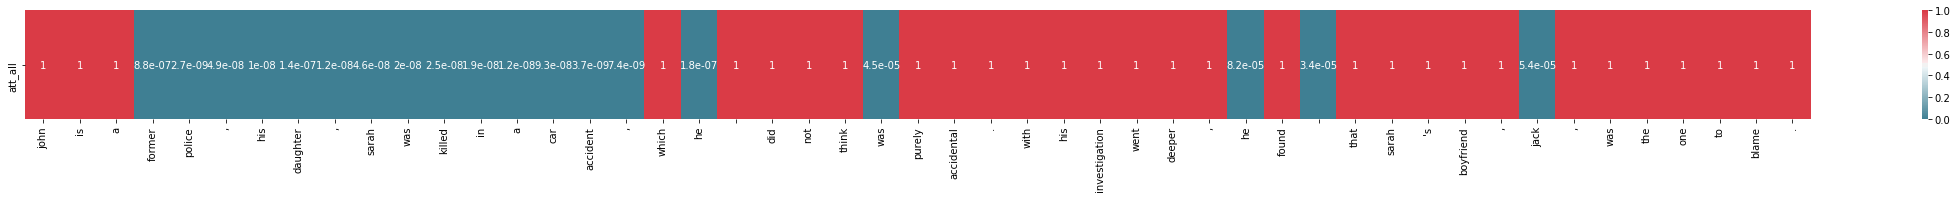

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.squeeze(att_right.asnumpy(), 0).shape
plt.figure(figsize=(40,2))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(np.squeeze(att_right.sum(axis=1, keepdims=True).asnumpy(), 0), cmap=cmap, annot=True,
            xticklabels=tokenizer(right), yticklabels=['att_all'])
plt.show()

## Conclusion
Word embedding can effectively represent the semantic similarity between words, which brings many breakthroughs for complex natural language processing tasks. The attention mechanism can intuitively grasp the important semantic features in the sentence. The LSTM captures the word order relationship between words in a sentence. Through word embedding, LSTM and attention mechanisms work together to effectively represent the semantics of a sentence and apply it to many practical tasks.

GluonNLP provides us with many efficient and convenient tools to help us experiment quickly. This greatly simplifies the tedious work of natural language processing.

## Reference
1. [A Structured Self-Attentive Sentence Embedding](https://arxiv.org/pdf/1703.03130.pdf)
2. [Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing](https://nlp.stanford.edu/pubs/glove.pdf)
3. [Long short-term memory](https://www.bioinf.jku.at/publications/older/2604.pdf)